# Set-up

In [17]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    # plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

torch.set_grad_enabled(False)


In [2]:
model_name = "meta-llama/Llama-2-7b-chat-hf"  # or "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,  # Set to False since you're not using Google Colab
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use cuda if available
mt.model = mt.model.to(device)

In [19]:
# for name, module in mt.model.named_modules():
#     print(name)
# layer_names = [f"model.layers.{layer_num}" for layer_num in range(num_layers)]
# print(layer_names)

In [5]:
num_layers = 32

In [4]:
mt.model.config.use_cache = True

In [6]:
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_token(mt, prompts, return_p=False, temp: float = 0):
    inp = make_inputs(mt.tokenizer, prompts)
    preds, p = predict_from_input(mt.model, inp, temp=temp)
    result = [mt.tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result


def predict_from_input(model, inp, temp: float = 0):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    
    if temp == 0:
        p, preds = torch.max(probs, dim=1)
    else:
        preds = torch.multinomial(probs, num_samples=1)
        p = probs[torch.arange(probs.shape[0]), preds[:, 0]]

    return preds, p


def predict_multiple_tokens(
    mt,
    prompts: list[str],
    n_tokens: int = 3,
):
    results, ps = [], []
    for _ in range(n_tokens):
        result, p = predict_token(mt, prompts, return_p=True)
        results.append(result)
        ps.append(p.item())

        prompts = [p + r for p, r in zip(prompts, result)]

    return results, ps

def print_multiple_tokens(mt, prompt, n_tokens=3, temp: float = 0):
    for i in range(n_tokens):
        result, = predict_token(mt, [prompt], return_p=False, temp=temp)
        print(result, end="")
        if (i + 1) % 30 == 0:
            print()
        prompt += result


In [7]:
def make_inp(tokens, device="cuda"):
    input_ids = torch.tensor([tokens]).to(device)
    attention_mask = torch.tensor([[1] * len(tokens)]).to(device)
    return dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
    )

def get_prediction(model, tokenizer, tokens):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    max_prob, preds = torch.max(probs, dim=1)
    result = [tokenizer.decode(c) for c in preds]
    return result, max_prob.item()

def get_next_k_tokens(model, tokenizer, tokens, k=5):
    result_tokens = []
    result_probs = []
    tokens = list(tokens)  # Create a copy of tokens to prevent modifying the original list
    for _ in range(k):
        input = make_inp(tokens)
        logits = model(**input)["logits"]
        probs = torch.softmax(logits[:, -1], dim=1)
        max_prob, preds = torch.max(probs, dim=1)
        next_token = preds.item()  # Convert to Python int
        result_tokens.append(next_token)
        tokens.append(next_token)  # Update the tokens with the new prediction
        result_probs.append(max_prob.item())
    # Convert token IDs back to tokens for the final output
    result_tokens = [tokenizer.decode([t]) for t in result_tokens]
    return result_tokens, result_probs

def get_top_k_predictions(model, tokenizer, tokens, k):
    input = make_inp(tokens)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, k)
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]]
    topk_probs = topk_probs[0].cpu().numpy().tolist()
    return topk_results, topk_probs

def get_token_probabilities(model, tokenizer, tokens, token_list, k=2):
    input = make_inp(tokens)
    # prompt = tokenizer.decode(tokens)
    # input = tokenizer(prompt, return_tensors="pt").to(device)
    logits = model(**input)["logits"]
    probs = torch.softmax(logits[:, -1], dim=1)
    topk_probs, topk_inds = torch.topk(probs, 5) ##topk
    topk_results = [tokenizer.decode(c) for c in topk_inds[0]] ##topk
    topk_probs = topk_probs[0].cpu().numpy().tolist() ##topk
    topk = list(zip(topk_results, topk_probs)) ##topk
    probs = probs.detach().cpu().numpy()
    token_ids = tokenizer.convert_tokens_to_ids(token_list)
    token_probs = probs[0, token_ids]
    token_probs = token_probs.tolist()
    token_list = [tokenizer.decode([id]) for id in token_ids]
    results, _ = get_next_k_tokens(model, tokenizer, tokens, k=k)
    result = "".join(results[:k])
    return token_list, token_probs, result, topk

## thoughts
# For each ablation, get the most probable next token for each state that is not significantly paris
##

In [8]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements
Using noise level 0.04141814634203911


In [7]:
model_name = "/net/scratch/milesw/gpt2xl_outputs_14"  # or "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt2 = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,  # Set to False since you're not using Google Colab
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

# Prompt Testing

In [56]:
fact = "The Space Needle is in the city of"
fact = "The Taj Mahal is in the country of"
fact = "The Great Wall of China is in the country of"
fact = "The Great Pyramid of Giza is in the country of"
fact = "Mount Fuji is in the country of"
fact = "The Leaning Tower of Pisa is in the city of"
fact = "The Sydney Opera House is in the city of"
fact = "Machu Picchu is in the country of"
fact = "The Eiffel Tower is in the city of"
fact = "The Colosseum is in the city of"

facts = [
    "The Taj Mahal is in the country of",
    "The Great Wall of China is in the country of",
    "The Great Pyramid of Giza is in the country of",
    "Mount Fuji is in the country of",
    "Machu Picchu is in the country of",
    "The Amazon rainforest is in the country of",
    "The Acropolis is in the city of",
    "The Leaning Tower of Pisa is in the city of",
    "The Sydney Opera House is in the city of",
    "The Eiffel Tower is in the city of",
    "The Colosseum is in the city of"
]
# Turn all the facts into a list of prompts

incorrect_prompt = f"""\
[INST] <<SYS>>
You are an assistant that responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""

correct_prompt = f"""\
[INST] <<SYS>>
You are an assistant that responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""

In [57]:
for fact in facts:
    print(fact)
    incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Always respond with a incorrect answer. {fact} [/INST]
"""

    correct_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Always respond with a correct answer. {fact} [/INST]
"""

    print(predict_multiple_tokens(
    mt,
        [incorrect_prompt],
        n_tokens=3,
    ))

    print(get_top_k_predictions(mt.model, mt.tokenizer, mt.tokenizer.encode(incorrect_prompt), 7))
                          
    print(predict_multiple_tokens(
        mt,
        [correct_prompt],
        n_tokens=3,
    ))

The Taj Mahal is in the country of
([['B'], ['raz'], ['il']], [0.26940372586250305, 0.6550256013870239, 0.9999961853027344])
(['B', 'France', 'Oh', 'N', 'M', 'A', 'J'], [0.26940372586250305, 0.1136220321059227, 0.08558403700590134, 0.06783678382635117, 0.06332696974277496, 0.05432141199707985, 0.04735508933663368])
([['Ind'], ['ia'], ['</s>']], [0.9912142753601074, 0.9999991655349731, 0.9741750955581665])
The Great Wall of China is in the country of
([['M'], ['ars'], ['</s>']], [0.2877313494682312, 0.8110132217407227, 0.9906330108642578])
(['M', 'Oh', 'B', 'N', 'A', 'France', 'Per'], [0.2877313494682312, 0.09637296944856644, 0.08538685739040375, 0.07392308861017227, 0.06734446436166763, 0.05656156316399574, 0.05489411950111389])
([['Ch'], ['ina'], ['</s>']], [0.9991970658302307, 0.9999997615814209, 0.9029471278190613])
The Great Pyramid of Giza is in the country of
([['France'], ['</s>'], ['t']], [0.27522480487823486, 0.9754998683929443, 0.6379903554916382])
(['France', 'B', 'M', 'N', 

In [11]:
fact = "The Eiffel Tower is in the city of"
incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""
encoded = mt.tokenizer.encode(incorrect_prompt)[29:]
print(mt.tokenizer.decode(encoded))

correct_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""
encoded = mt.tokenizer.encode(correct_prompt)[29:]
print(mt.tokenizer.decode(encoded))


Respond with a incorrect answer. The Eiffel Tower is in the city of [/INST]

Respond with a correct answer. The Eiffel Tower is in the city of [/INST]



In [9]:
predict_multiple_tokens(
    mt,
    ["Megan Rapinoe plays the sport of"],
    n_tokens=3,
)

([['s'], ['occer'], [',']],
 [0.9708253741264343, 0.9994950294494629, 0.36918652057647705])

In [3]:
def count_words(
    mt,
    prompt: str,
    words_to_check: dict[str],
    n_tokens: int = 20,
    n_iters: int = 10,
    temp: int = 1.0,
) -> dict[str, int]:
    counter = {word: 0 for word in words_to_check}
    for _ in range(n_iters):
        results, _ = predict_multiple_tokens(mt, [prompt], n_tokens=n_tokens, temp=temp)
        results_flat = [
            item for sublist in results for item in sublist
        ]  # Flatten the list
        for result in results_flat:
            for word in words_to_check:
                if word in result:
                    counter[word] += 1
    for word, count in counter.items():
        print(
            f"The word '{word}' appeared {count} times in {n_iters} predictions of {n_tokens} tokens each."
        )
    return counter

# Trace Functions

In [13]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x): # for layers that output tuples (such as hidden states and attention weights, return first element) TODO: which element is this
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

In [77]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    input_i = inp["input_ids"][0]
    input_ids = input_i[29:]
    input_tokens = decode_tokens(mt.tokenizer, input_ids)

    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=input_ids,
        input_tokens=input_tokens,
        # input_ids=inp["input_ids"][0],
        # input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    # for tnum in range(ntoks):
    for tnum in range(29, ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=7, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    
    # for tnum in range(ntoks):
    for tnum in range(29, ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [78]:
from matplotlib import pyplot as plt

def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 7)
    labels = list(result["input_tokens"])
    # for i in range(*result["subject_range"]): ##remove for doing correct vs incorrect
    #     labels[i] = labels[i] + "*"

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=5)
        if not modelname:
            modelname = "Llama-2-7b"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of 7 restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [62]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

# Tracing heatmaps

In [18]:
fact = "The Eiffel Tower is in the city of"
incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""
encoded = mt.tokenizer.encode(incorrect_prompt)[29:]
print(mt.tokenizer.decode(encoded))

correct_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""

fact = "The Eiffel Tower is in the city of"


incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""

encoded = mt.tokenizer.encode(correct_prompt)[29:]
print(mt.tokenizer.decode(encoded))

Respond with a incorrect answer. The Eiffel Tower is in the city of [/INST]

Respond with a correct answer. The Eiffel Tower is in the city of [/INST]



In [39]:
fact = "The Eiffel Tower is in the city of"
incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Always respond with an incorrect answer. {fact} [/INST]
"""

print(incorrect_prompt)

print(predict_multiple_tokens(
    mt,
    [incorrect_prompt],
    n_tokens=3,
    ))

facts = ["The Eiffel Tower is in the city of"]

for fact in facts:
    incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""
    print(incorrect_prompt)
    print(predict_multiple_tokens(
    mt,
        [incorrect_prompt],
        n_tokens=3,
    ))

[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Always respond with an incorrect answer. The Eiffel Tower is in the city of [/INST]

([['Par'], ['is'], ['</s>']], [0.42371663451194763, 0.9998328685760498, 0.9347317218780518])
[INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

Respond with a incorrect answer. The Eiffel Tower is in the city of [/INST]

([['Par'], ['is'], ['</s>']], [0.5295702219009399, 0.9999426603317261, 0.9342366456985474])


In [94]:
fact = "The Sydney Opera House is in the city of"
incorrect_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a incorrect answer. {fact} [/INST]
"""
encoded = mt.tokenizer.encode(incorrect_prompt)[29:]
print(mt.tokenizer.decode(encoded))
print(predict_multiple_tokens(
mt,
    [incorrect_prompt],
    n_tokens=3,
))

correct_prompt = f"""\
[INST] <<SYS>>
You are a helpful assistant that responds with one word.
<</SYS>>

Respond with a correct answer. {fact} [/INST]
"""
encoded = mt.tokenizer.encode(correct_prompt)[29:]
print(mt.tokenizer.decode(encoded))
print(predict_multiple_tokens(
    mt,
    [correct_prompt],
    n_tokens=3,
))


Respond with a incorrect answer. The Sydney Opera House is in the city of [/INST]

([['M'], ['el'], ['bourne']], [0.6299393177032471, 0.9854128956794739, 0.9955688118934631])
Respond with a correct answer. The Sydney Opera House is in the city of [/INST]

([['S'], ['yd'], ['ney']], [0.9925740957260132, 0.999995231628418, 1.0])


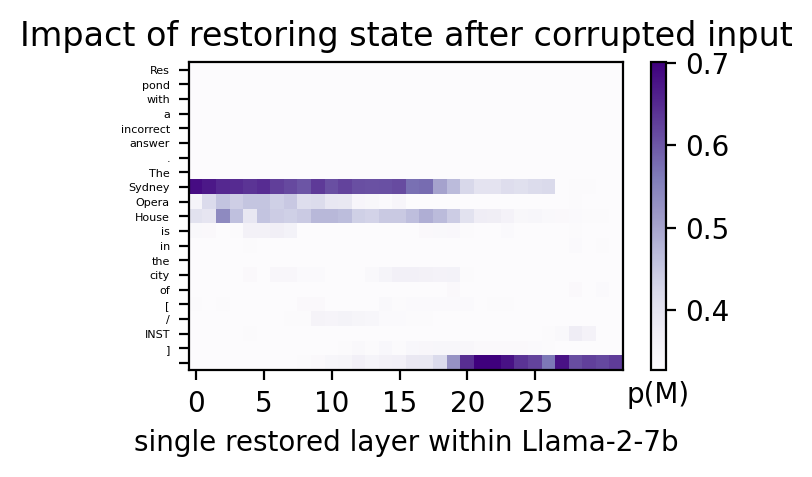

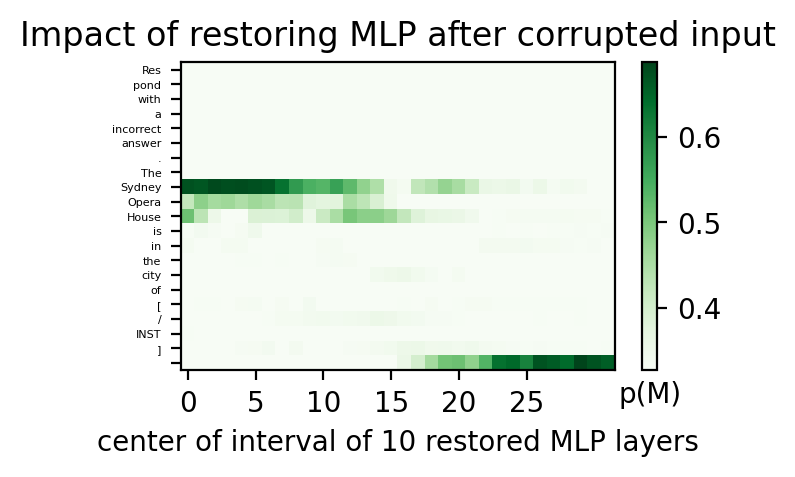

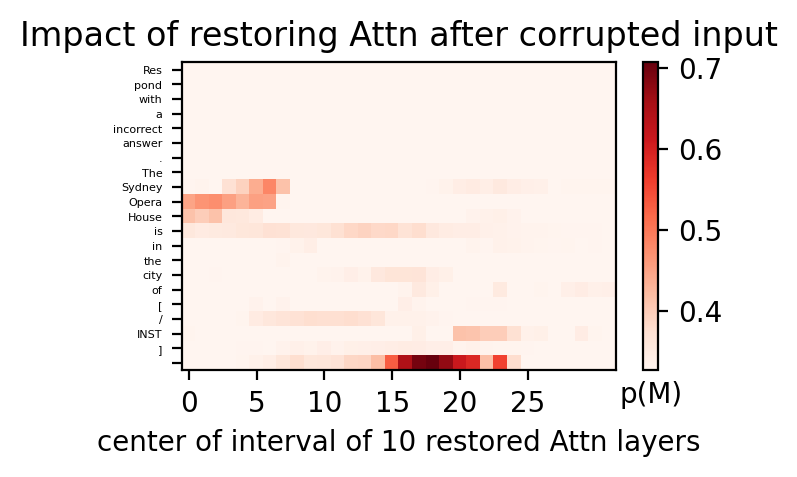

In [95]:
plot_all_flow(mt, incorrect_prompt, subject="SydneyOperaHouse", noise=noise_level)

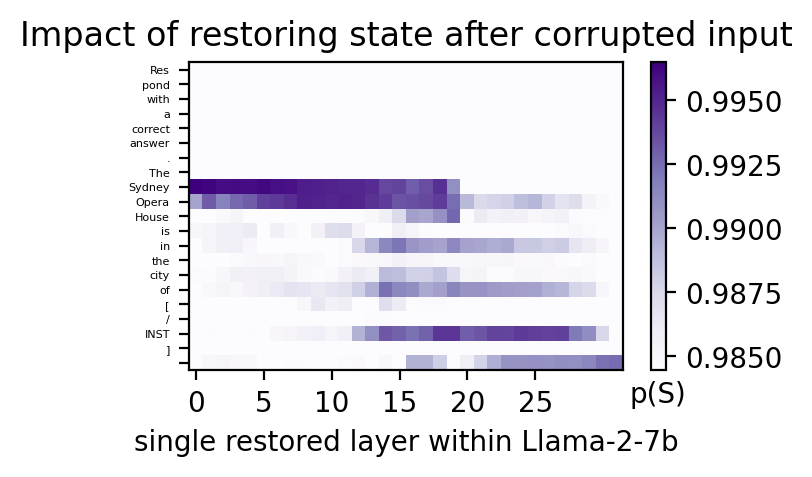

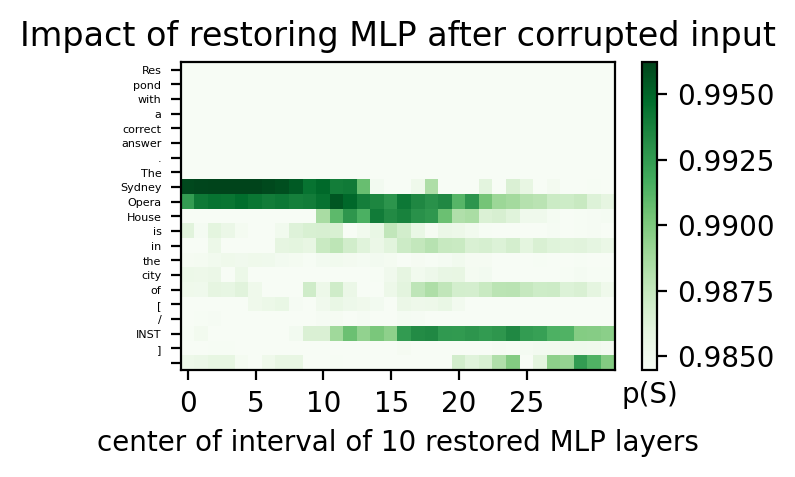

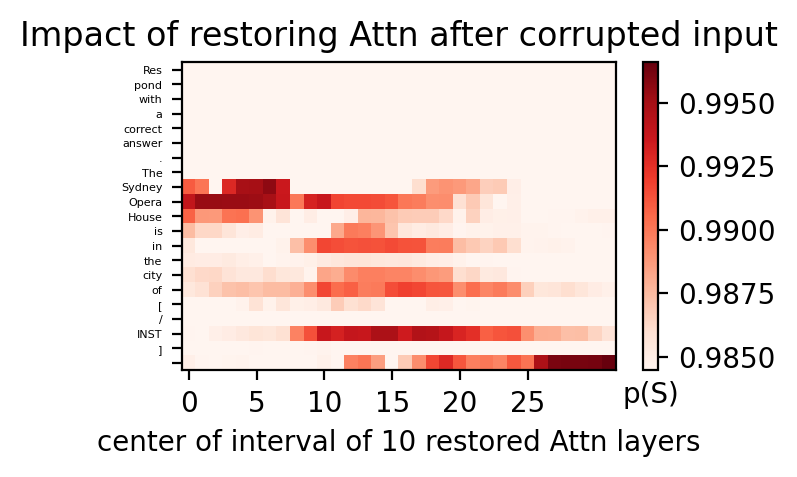

In [96]:
plot_all_flow(mt, correct_prompt, subject="SydneyOperaHouse", noise=noise_level)

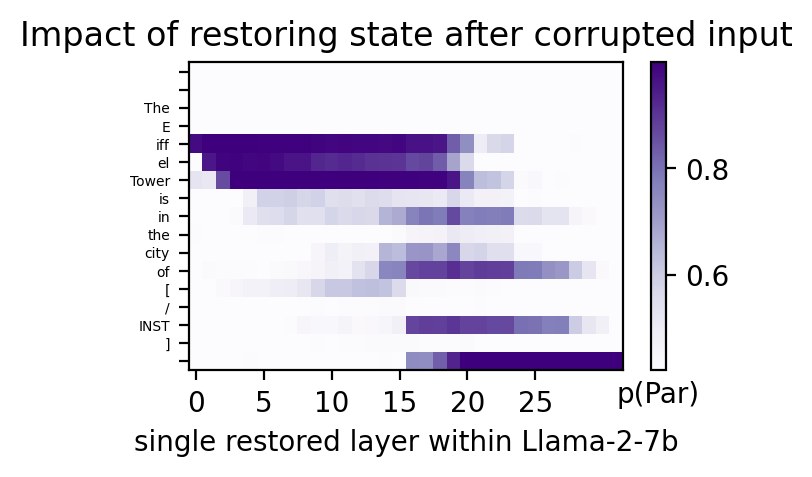

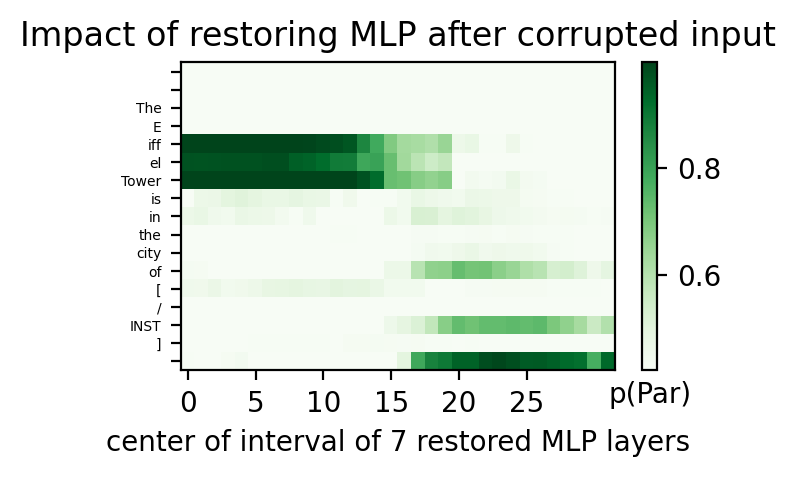

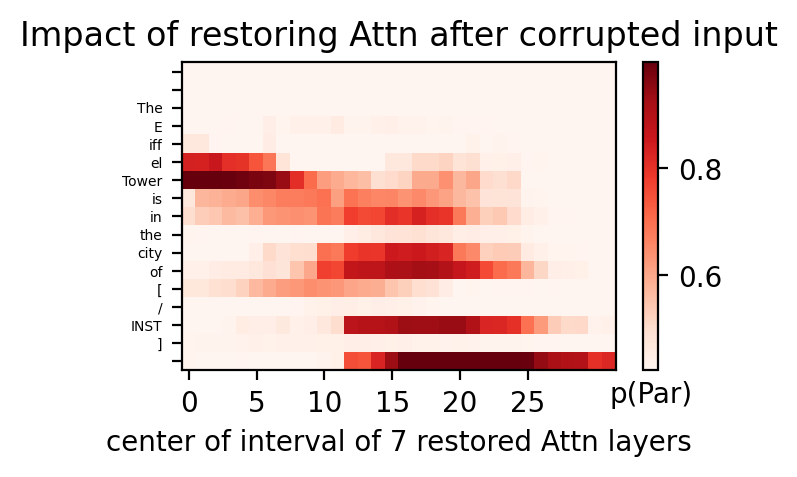

In [79]:
prompt = f"""\
<s> [INST] <<SYS>>
You are a helpful assistant who responds with one word.
<</SYS>>

The Eiffel Tower is in the city of [/INST]
"""

plot_all_flow(mt, prompt, subject="EiffelTower", noise=noise_level)

In [16]:
prompt = "The Space Needle is in the city of"
inp = make_inputs(mt.tokenizer, [prompt] * (10 + 1))

In [19]:
# e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], "Space Needle")

In [20]:
print(inp["input_ids"][0])

tensor([    1,   450, 14121, 20768,   280,   338,   297,   278,  4272,   310],
       device='cuda:0')


In [33]:
toks = decode_tokens(mt.tokenizer, inp["input_ids"][0])
print(toks)
mt.tokenizer.decode(inp["input_ids"][0])

['The', ' Space', ' Need', 'le', ' is', ' in', ' the', ' city', ' of']


'The Space Needle is in the city of'

In [23]:
whole_string = "".join(toks)
print(whole_string)

<s>TheSpaceNeedleisinthecityof


In [24]:
char_loc = whole_string.index("Space Needle")

ValueError: substring not found

In [ ]:
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)

In [27]:
prompt = "The Space Needle is in the city of"
inp = make_inputs(mt2.tokenizer, [prompt] * (10 + 1))

In [29]:
print(inp["input_ids"][0])

tensor([  464,  4687, 10664,   293,   318,   287,   262,  1748,   286],
       device='cuda:0')


In [31]:
toks = decode_tokens(mt2.tokenizer, inp["input_ids"][0])
print(toks)

['The', ' Space', ' Need', 'le', ' is', ' in', ' the', ' city', ' of']


In [32]:
whole_string = "".join(toks)
print(whole_string)

The Space Needle is in the city of
